In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
#%% hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 352
ACTIONS = np.arange(6)

In [11]:
#FUNCTION FOR COMPUTING SMOOTH AVERAGE REWARD AND CONFIDENCE INTERVAL
def compute_results(rewards,window_size,n_episodes):
    from scipy.stats import t
    def moving_average(a, n):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    rewards = np.array(rewards).reshape(-1,n_episodes)
    mean = np.mean(rewards,axis=0)
    std = np.std(rewards,axis=0) 
    smoothed_reward = moving_average(mean,window_size)
    N=rewards.shape[0]
    dof = N-1
    alpha=0.05

    t_crit = np.abs(t.ppf((alpha)/2,dof))
    upper_curve = mean+std*t_crit/np.sqrt(N)
    lower_curve = mean-std*t_crit/np.sqrt(N)
    return smoothed_reward,upper_curve,lower_curve

In [12]:
#FUNCTION FOR RECORDING ENVIRONMENT 
def test(agent,n_step=20,path='.'):
    import gymnasium
    Q = agent.return_best_Q()

    if not os.path.exists(path):
        os.makedirs(path)
    env = gymnasium.make('Taxi-v3',render_mode='rgb_array')
    state= env.reset()[0]
    for i in range(n_step):
        action = np.argmax(Q[state])
        state,_,done,_,_ = env.step(action)
        plt.imsave(os.path.join(path,f'{i}.jpg'),env.render())
        if done:break


In [13]:
#AGENT BASE CLASS, OTHER AGENTS WOULD INHERIT FROM THIS CLASS
class AgentBase():
    def __init__(self,epsilon,discount_factor):
        self._env = gym.make('Taxi-v3')
        self._seed = STUDENT_NUM
        #ARRAY FOR SAVING Q VALUESS
        self._Q = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
        #A LIST OF ALL EPISODES REWARDS FOR PLOTTING THE RESULTS
        self._total_reward = []
        self.eps = epsilon
        self._gamma = discount_factor
        #BEST Q VALUES ARE SAVED FOR TESTING THE AGENT
        self._best_Q =None
        self._best_reward =-1e500
        

    def _eps_greedy(self,state):
        #EPSILON GREEDY POLICY
        if np.random.random() > self.eps: action = np.argmax(self._Q[state])
        else: action = self._env.action_space.sample()
        return action
    def render(self):
        self._env.render()
    def reset(self):
        self._Q = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
    def reset_env(self,set_seed=False):
        if set_seed:self._env.seed(self._seed)
        self._state = self._env.reset()
    def return_best_Q(self):
        return self._best_Q

# Part 1:

In [14]:
class Q_learning(AgentBase):
        def __init__(self, epsilon, discount_factor,learning_rate):
            AgentBase.__init__(self,epsilon,discount_factor)
            self.lr = learning_rate
        def step(self):

            episode_reward=0

            done=False

            while not done:
        
                bestAction=self._eps_greedy(self._state)
                
                next_state,reward,done,_ = self._env.step(bestAction)

                self._Q[self._state,bestAction]+=self.lr*(reward+ self._gamma*(np.max(self._Q[next_state]))\
                    - self._Q[self._state,bestAction])
        
                episode_reward+=reward

                if done:
                    break
            
                self._state = next_state
            #IF THE EPISODE'S REWARD WAS BETTER THAN THE LAST ONE IT'S Q VALUE IS SAVED FOR TEST
            if episode_reward > self._best_reward:
                self._best_reward = episode_reward
                self._best_Q = self._Q
            return episode_reward
       

Constant Learning rate

In [15]:
total_reward =[]
q_learnig = Q_learning(EPSILON,DISCOUNT,LEARNING_RATE)
for rep in range(REPS):
    q_learnig.reset()
    for episode in range(EPISODES):
        #DECREASE EPSILON
        q_learnig.eps =  max(1e-3, np.exp(-0.01*episode)) * EPSILON
        q_learnig.reset_env()
        episode_reward = q_learnig.step()
        #SAVE EPISODE REWARD
        total_reward.append(episode_reward)
#TEST AGENT BEHAVIOUR IN ENVIRONMENT
test(q_learnig,path='./videos/q_learning/constant')

Decaying Learning rate

In [16]:
total_reward_2 =[]
q_learnig = Q_learning(EPSILON,DISCOUNT,LEARNING_RATE)
for rep in range(REPS):
    q_learnig.reset()
    for episode in range(EPISODES):
        q_learnig.lr =  max(1e-3, np.exp(-0.01*episode))
        #DECREASE LEARNING RATE
        q_learnig.eps =  max(1e-3, np.exp(-0.01*episode)) * EPSILON
        q_learnig.reset_env()
        episode_reward = q_learnig.step()
        total_reward_2.append(episode_reward)
test(q_learnig,path='./videos/q_learning/decaying')

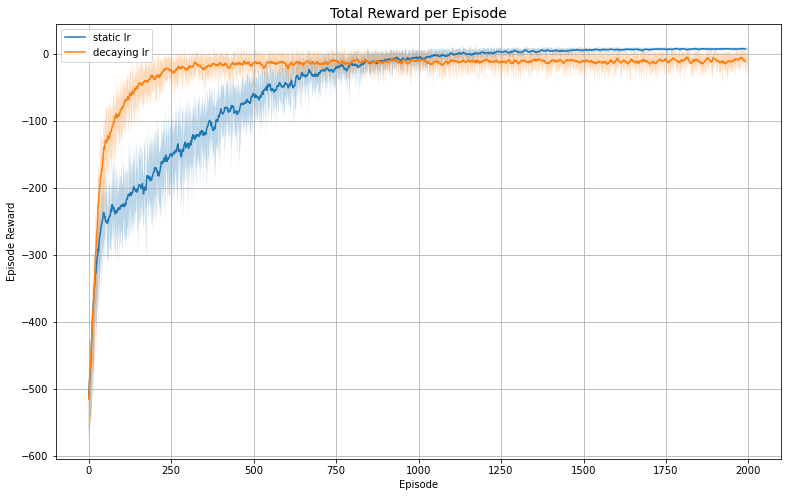

In [17]:
#CALCULATE SMOOTHED AVERAGE REWARD AND CONFIDENCE INTERVAL
static_eps= compute_results(total_reward,10,EPISODES)
decaying_eps= compute_results(total_reward_2,10,EPISODES)

plt.figure(figsize=(13,8))
plt.grid()
plt.plot(static_eps[0],label='static lr')
plt.fill_between(range(len(static_eps[1])),static_eps[1],static_eps[2],alpha=0.3)
plt.plot(decaying_eps[0],label='decaying lr')
plt.fill_between(range(len(decaying_eps[1])),decaying_eps[1],decaying_eps[2],alpha=0.3)
plt.title('Total Reward per Episode',size=14)
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.legend()
plt.show()

In [18]:
class n_step_sarsa(AgentBase):
    def __init__(self, epsilon, discount_factor,learning_rate,n):
        AgentBase.__init__(self,epsilon,discount_factor)
        self.lr = learning_rate
        #NUMBER OF N
        self.n = n
    def step(self):
        episode_reward=0
        actions = []
        states=[]
        rewards=[]
        T = 1e500
        t=0
        tau=0
        self.reset_env()
        states.append(self._state)

        bestAction = self._eps_greedy(self._state)

        actions.append(bestAction)

        while True:
            
            if t < T:

                next_state,reward,done,_ = self._env.step(bestAction)

                states.append(next_state)

                rewards.append(reward)
            
                episode_reward+=reward

                if done: T = t+1

                else:

                    bestAction = self._eps_greedy(next_state)
            
                    actions.append(bestAction)
                                  
            tau = t-self.n+1

            if tau >=0:
                G=0
                for i in range(tau+1,min(tau+self.n,T)+1):G+=(self._gamma**(i-tau-1))*rewards[i-1]
                        
                if tau+self.n < T: G+=(self._gamma**self.n)*self._Q[states[tau+self.n],actions[tau+self.n]]

                self._Q[states[tau],actions[tau]]+=self.lr*(G - self._Q[states[tau],actions[tau]])
                


            t+=1


            if tau==T-1: break
            
        if episode_reward > self._best_reward:
            self._best_reward = episode_reward
            self._best_Q = self._Q

        return episode_reward
        

In [19]:
sarsa_1 = n_step_sarsa(EPSILON,DISCOUNT,LEARNING_RATE,1)
sarsa_2 = n_step_sarsa(EPSILON,DISCOUNT,LEARNING_RATE,2)
sarsa_3 = n_step_sarsa(EPSILON,DISCOUNT,LEARNING_RATE,3)

In [20]:
total_reward_1 =[]
total_reward_2=[]
total_reward_3 =[]

for rep in range(REPS):
    sarsa_1.reset()
    sarsa_2.reset()
    sarsa_3.reset()
    for episode in range(EPISODES):
        sarsa_1.eps =  max(1e-3, np.exp(-0.01*episode))* EPSILON
        sarsa_2.eps =  max(1e-3, np.exp(-0.01*episode))* EPSILON
        sarsa_3.eps =  max(1e-3, np.exp(-0.01*episode))* EPSILON
        episode_reward = sarsa_1.step()
        total_reward_1.append(episode_reward)
        episode_reward = sarsa_2.step()
        total_reward_2.append(episode_reward)
        episode_reward = sarsa_3.step()
        total_reward_3.append(episode_reward)
test(sarsa_1,path='./videos/n_step_sarsa/1_step')
test(sarsa_2,path='./videos/n_step_sarsa/2_step')
test(sarsa_3,path='./videos/n_step_sarsa/3_step')

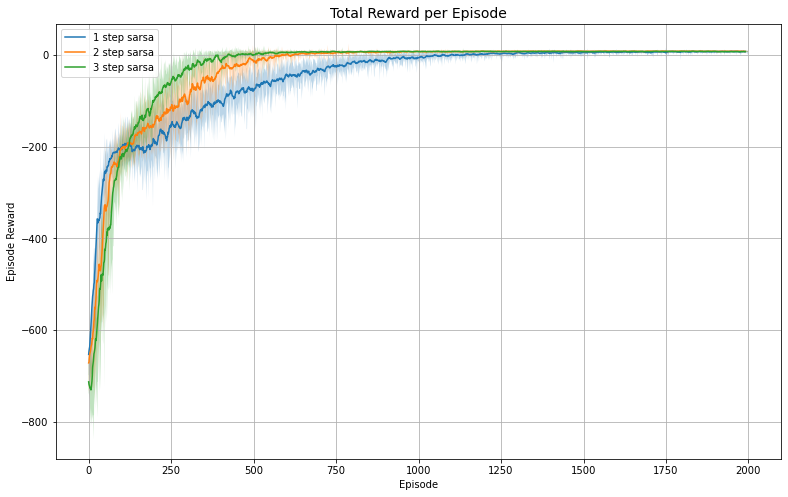

In [21]:
n_1= compute_results(total_reward_1,10,EPISODES)
n_2= compute_results(total_reward_2,10,EPISODES)
n_3= compute_results(total_reward_3,10,EPISODES)

plt.figure(figsize=(13,8))
plt.grid()
plt.plot(n_1[0],label='1 step sarsa')
plt.fill_between(range(len(n_1[1])),n_1[1],n_1[2],alpha=0.3)
plt.plot(n_2[0],label='2 step sarsa')
plt.fill_between(range(len(n_2[1])),n_2[1],n_2[2],alpha=0.3)
plt.plot(n_3[0],label='3 step sarsa')
plt.fill_between(range(len(n_3[1])),n_3[1],n_3[2],alpha=0.3)
plt.title('Total Reward per Episode',size=14)
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.legend()
plt.show()

In [22]:
class n_tree_backup(AgentBase):
    def __init__(self, epsilon, discount_factor,learning_rate,n):
        AgentBase.__init__(self,epsilon,discount_factor)
        self.lr = learning_rate
        self.n = n
    def step(self):
        episode_reward=0
        actions = []
        states=[]
        rewards=[]
        T = 1e500
        t=0
        tau=0
        
        self.reset_env()

        states.append(self._state)


        bestAction = self._eps_greedy(self._state)

        actions.append(bestAction)
        
        while True:
            
            if t < T:

                next_state,reward,done,_ = self._env.step(bestAction)

                states.append(next_state)

                rewards.append(reward)
            
                episode_reward+=reward

                if done: T = t+1

                else:

                    bestAction = self._eps_greedy(next_state)
            
                    actions.append(bestAction)
                                  
            tau = t-self.n+1

            if tau >=0:

                if t+1 >= T:G = rewards[T-1]
                else:
                    #P IS THE POLICY PROBABLITY FOR THAT SPECIFIC STATE
                    P = np.full(shape=(self._env.action_space.n),fill_value = self.eps/self._env.action_space.n)
                    P[np.argmax(self._Q[next_state])]+=(1-self.eps)
                    G = rewards[t] + np.sum([self._gamma* P[i]*self._Q[next_state,i] for i in range(self._env.action_space.n)])
                for k in range(min(t,tau-1)+1,tau-1,-1):
                    P = np.full(shape=(self._env.action_space.n),fill_value = self.eps/self._env.action_space.n)
                    P[np.argmax(self._Q[states[k]])]+=(1-self.eps)
                    G = rewards[k]+ np.sum([self._gamma* P[i]*self._Q[states[k],i] for i in range(self._env.action_space.n) if i != actions[k]]) \
                        + self._gamma* P[actions[k]] * G

                self._Q[states[tau],actions[tau]]+=self.lr*(G - self._Q[states[tau],actions[tau]])
                

            t+=1

            if tau==T-1: break

        if episode_reward > self._best_reward:
            self._best_reward = episode_reward
            self._best_Q = self._Q
        return episode_reward


In [23]:
tree_1 = n_tree_backup(EPSILON,DISCOUNT,LEARNING_RATE,1)
tree_2 = n_tree_backup(EPSILON,DISCOUNT,LEARNING_RATE,2)
tree_3 = n_tree_backup(EPSILON,DISCOUNT,LEARNING_RATE,3)
total_reward_1 =[]
total_reward_2=[]
total_reward_3 =[]

for rep in range(REPS):
    tree_1.reset()
    tree_2.reset()
    tree_3.reset()
    for episode in range(EPISODES):
        tree_1.eps=  max(1e-3, np.exp(-0.01*episode))* EPSILON
        tree_2.eps=  max(1e-3, np.exp(-0.01*episode))* EPSILON
        tree_3.eps=  max(1e-3, np.exp(-0.01*episode))* EPSILON
        episode_reward = tree_1.step()
        total_reward_1.append(episode_reward)
        episode_reward = tree_2.step()
        total_reward_2.append(episode_reward)
        episode_reward = tree_3.step()
        total_reward_3.append(episode_reward)
test(tree_1,path='./videos/n_step_tree/1_step')
test(tree_2,path='./videos/n_step_tree/2_step')
test(tree_3,path='./videos/n_step_tree/3_step')


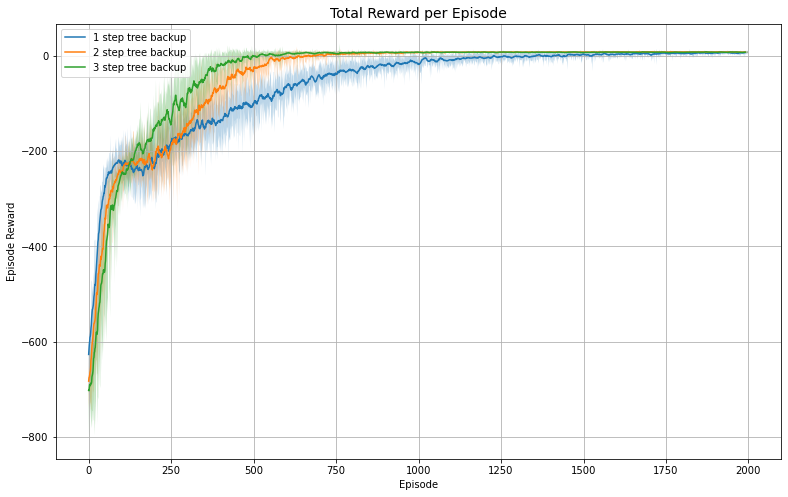

In [24]:
t_1= compute_results(total_reward_1,10,EPISODES)
t_2= compute_results(total_reward_2,10,EPISODES)
t_3= compute_results(total_reward_3,10,EPISODES)

plt.figure(figsize=(13,8))
plt.grid()
plt.plot(t_1[0],label='1 step tree backup')
plt.fill_between(range(len(t_1[1])),t_1[1],t_1[2],alpha=0.3)
plt.plot(t_2[0],label='2 step tree backup')
plt.fill_between(range(len(t_2[1])),t_2[1],t_2[2],alpha=0.3)
plt.plot(t_3[0],label='3 step tree backup')
plt.fill_between(range(len(t_3[1])),t_3[1],t_3[2],alpha=0.3)
plt.title('Total Reward per Episode',size=14)
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.legend()
plt.show()

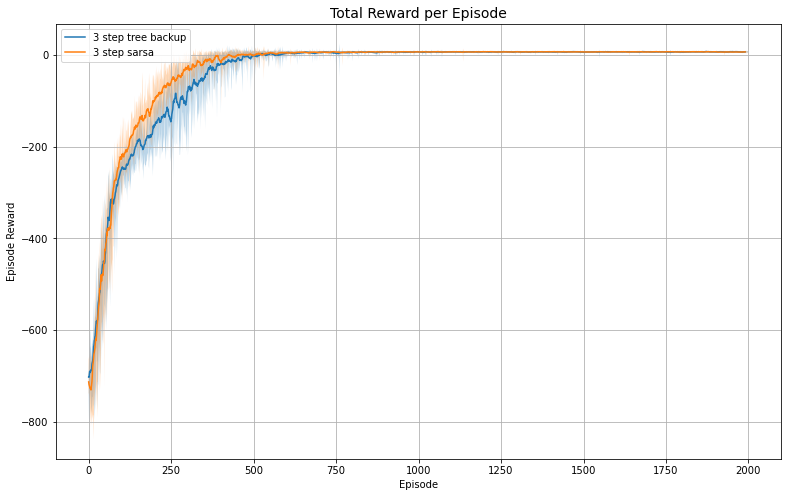

In [25]:
plt.figure(figsize=(13,8))
plt.grid()
plt.plot(t_3[0],label='3 step tree backup')
plt.fill_between(range(len(t_3[1])),t_3[1],t_3[2],alpha=0.3)

plt.plot(n_3[0],label='3 step sarsa')
plt.fill_between(range(len(n_3[1])),n_3[1],n_3[2],alpha=0.3)

plt.title('Total Reward per Episode',size=14)
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.legend()
plt.show()

# Part 4-a:

In [26]:
class on_policy_MC(AgentBase):
    def __init__(self, epsilon, discount_factor):
        AgentBase.__init__(self,epsilon,discount_factor)
        self.returns = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
        self.n_returns = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
    def reset(self):
        self._Q = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
        self.returns = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
        self.n_returns = np.zeros(shape=(self._env.observation_space.n,self._env.action_space.n))
    def step(self):
        self.reset_env(set_seed=True)
        done = False
        action_states = []
        rewards =[]
        episode_reward = 0
        while not done:
            bestAction = self._eps_greedy(self._state)
            action_states.append([self._state,bestAction])
            next_state,reward,done,_ = self._env.step(bestAction)
            rewards.append(reward)
            episode_reward+=reward
            
            if done:break

            self._state = next_state
        G = 0
        for i in range(len(action_states)-1,-1,-1):
            G = self._gamma*G + rewards[i]
            if action_states[i] not in action_states[:i]:
                self.returns[action_states[i][0],action_states[i][1]]+=G
                self.n_returns[action_states[i][0],action_states[i][1]]+=1
                self._Q[action_states[i][0],action_states[i][1]] = self.returns[action_states[i][0],action_states[i][1]] \
                     / self.n_returns[action_states[i][0],action_states[i][1]]
        if episode_reward > self._best_reward:
            self._best_reward = episode_reward
            self._best_Q = self._Q
        return episode_reward

In [27]:
monte_carlo = on_policy_MC(0.5,DISCOUNT)
monte_carlo_2 = on_policy_MC(0.1,DISCOUNT)
total_reward =[]
total_reward_2=[]
for rep in range(REPS):
    monte_carlo.reset()
    monte_carlo_2.reset()
    for episode in range(EPISODES):
        monte_carlo.eps =  max(1e-3, np.exp(-0.001*episode))* 0.5
        episode_reward = monte_carlo.step()
        total_reward.append(episode_reward)
        episode_reward = monte_carlo_2.step()
        total_reward_2.append(episode_reward)
test(monte_carlo,path='./videos/monte_carlo/decaying')
test(monte_carlo_2,path='./videos/monte_carlo/constant')


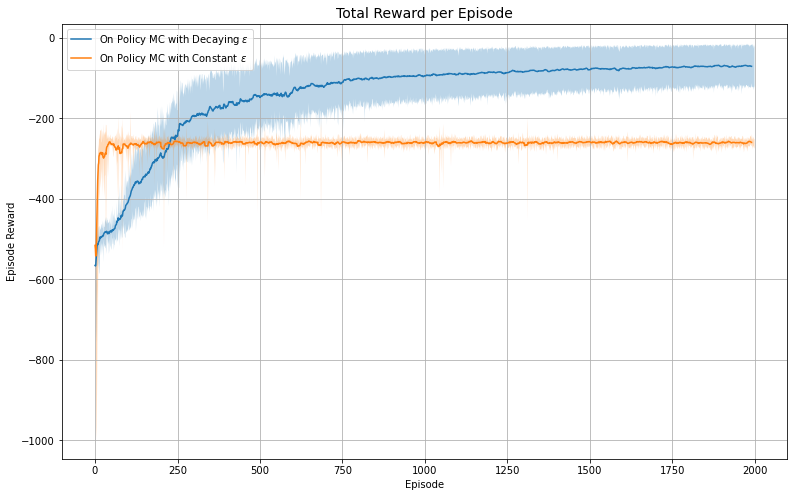

In [28]:
n_1= compute_results(total_reward,10,EPISODES)
n_2= compute_results(total_reward_2,10,EPISODES)


plt.figure(figsize=(13,8))
plt.grid()
plt.plot(n_1[0],label='On Policy MC with Decaying $\epsilon$')
plt.fill_between(range(len(n_1[1])),n_1[1],n_1[2],alpha=0.3)
plt.plot(n_2[0],label='On Policy MC with Constant $\epsilon$')
plt.fill_between(range(len(n_2[1])),n_2[1],n_2[2],alpha=0.3)

plt.title('Total Reward per Episode',size=14)
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.legend()
plt.show()